In [1]:
import pandas as pd
import json

%matplotlib inline
%load_ext autoreload
%autoreload

In [2]:
from approved_venders import get_approved_venders, get_arizona_listings
from approved_venders import get_listings_near, batch_listings_near, batch_arizona_listings

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
matplotlib.style.use('ggplot')

### vender information

In [ ]:
venders = pd.DataFrame(json.loads(get_approved_venders())['bundle'])
venders.to_csv('../../data/Approved_Vendors.csv')

In [ ]:
venders.activeListings.describe()

In [ ]:
mesa_df = pd.DataFrame(json.loads(get_listings_near(offset=0))['bundle'])
#venders.to_csv('../../data/Approved_Vendors.csv')

In [ ]:
mesa_list = batch_listings_near()
mesa_df = pd.concat(mesa_list, axis=0)
mesa_df.to_csv('../../data/city_mesa_df.csv')

In [ ]:
phoenix_list = get_arizona_listings("phoenix")
phoenix_df = pd.concat(phoenix_list, axis=0)
phoenix_df.to_csv('../../data/city_phoenix_df.csv')

### Get AZ Listings

In [ ]:
az_list = batch_arizona_listings()
az_df = pd.concat(az_list2, axis=0)
az_df.to_csv('../../data/az_df.csv')

### common utilties

In [413]:
def gen_filters(indexes):
    list_of_indexes = [i for i in indexes.items()]

    filter_criteria = list_of_indexes[0][1]
    for i, (k,v) in enumerate(list_of_indexes):
        try:
            print(k, sum(v))
            filter_criteria = (filter_criteria & list_of_indexes[i+1][1])
        except IndexError:
            pass

    return filter_criteria

### generate data

In [414]:
from IPython.display import HTML

In [415]:
phoenix_df = pd.read_csv('../../data/city_phoenix_df.csv', index_col=0)

### Investigate

In [416]:
phoenix_df.city.value_counts()

Phoenix       2388
Mesa            81
Tempe            9
Gilbert          6
Scottsdale       3
Chandler         1
Name: city, dtype: int64

In [417]:
pd.crosstab([phoenix_df.media.notnull(), phoenix_df.status], phoenix_df.closePrice.notnull())

closePrice             False  True 
media status                       
False Active              39      0
      Cancelled           70      0
      Closed               0    730
      Expired              7      0
      Pending              8      0
      Temp Off Market      6      0
True  Active            1590      0
      Pending             38      0

### Job Pipeline

In [420]:
pre_indexes = {
    "good_bedrooms": (phoenix_df.bedrooms <= 5),
    # "status": phoenix_df.status == 'Pending',
    # "good_datesold": (phoenix_df.dateSold > phoenix_df.listDate),
    # "has_close_price": phoenix_df.closePrice.notnull(),
}

In [421]:
pre_filter_criteria = gen_filters(pre_indexes)

good_bedrooms 2467


In [422]:
p_df = phoenix_df.drop_duplicates()

In [423]:
cols = [
    'mlsListingID',
    'listDate',
    'dateSold',
    'price',
    'closePrice',
    'bedrooms',
    'baths',
    'squareFootage',
    'constructionMaterials',
    'subtype',
    'media',
    'status',
]


In [424]:
calc_df = phoenix_df.groupby('bedrooms').price.describe().unstack().reset_index()

post_df = pd.merge(phoenix_df[cols], calc_df, left_on='bedrooms', right_on='bedrooms', suffixes=['','_agg'], how='inner')

In [427]:
## generate new fields
post_df['job_value'] = (post_df['75%'] - post_df.price)/2.

In [428]:
post_indexes = {
    # "good_bedrooms": (phoenix_df.bedrooms <= 5),
    "status": post_df.status == 'Pending',
    "job_value": post_df.job_value > 0,
    # "good_datesold": (phoenix_df.dateSold > phoenix_df.listDate),
    # "has_close_price": phoenix_df.closePrice.notnull(),
}

In [429]:
post_filter_criteria = gen_filters(post_indexes)

status 46
job_value 1852


In [430]:
remove_cols = [
    'count',
    'mean',
    'std',
    'min',
    '25%',
    '50%',
    '75%',
    'max'
]

In [431]:
post_df = post_df[post_filter_criteria].sort_values(by='job_value', ascending=False)
final_df = post_df.drop(remove_cols, axis=1)


In [432]:
final_df.T.to_json('../../data/phoenix.json')

### Analysis

phoenix, pending


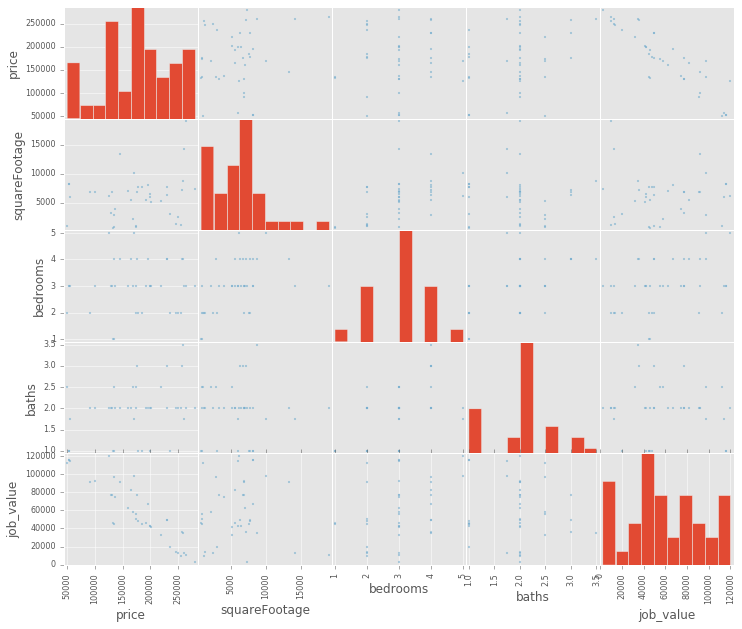

In [439]:
c = ['price', 'squareFootage', 'bedrooms', 'baths', 'job_value']
pd.scatter_matrix(final_df[c], figsize=(12,10))
print("phoenix, pending")

In [138]:
dt = pd.to_datetime(phoenix_df[cnull & ind].dateSold, unit='s').values

In [158]:
# remove_old (
# [cnull & ind]

[cnull & ind]

False    2453
True        3
dtype: int64

In [154]:
from datetime import datetime

In [155]:
phoenix_df.dateSold.dropna().apply(lambda x:datetime(x).Year)

TypeError: an integer is required (got type str)

In [140]:
pd.Series(1, dt).resample('D', how='sum')

2000-08-31     1
2000-09-01   NaN
2000-09-02   NaN
2000-09-03   NaN
2000-09-04   NaN
2000-09-05   NaN
2000-09-06   NaN
2000-09-07   NaN
2000-09-08   NaN
2000-09-09   NaN
2000-09-10   NaN
2000-09-11   NaN
2000-09-12   NaN
2000-09-13   NaN
2000-09-14   NaN
2000-09-15   NaN
2000-09-16   NaN
2000-09-17   NaN
2000-09-18   NaN
2000-09-19   NaN
2000-09-20   NaN
2000-09-21   NaN
2000-09-22   NaN
2000-09-23   NaN
2000-09-24   NaN
2000-09-25   NaN
2000-09-26   NaN
2000-09-27   NaN
2000-09-28   NaN
2000-09-29   NaN
              ..
2015-10-08   NaN
2015-10-09     1
2015-10-10   NaN
2015-10-11   NaN
2015-10-12   NaN
2015-10-13   NaN
2015-10-14     1
2015-10-15     1
2015-10-16     2
2015-10-17   NaN
2015-10-18   NaN
2015-10-19   NaN
2015-10-20   NaN
2015-10-21   NaN
2015-10-22   NaN
2015-10-23   NaN
2015-10-24   NaN
2015-10-25   NaN
2015-10-26   NaN
2015-10-27   NaN
2015-10-28   NaN
2015-10-29   NaN
2015-10-30     3
2015-10-31   NaN
2015-11-01   NaN
2015-11-02     1
2015-11-03     5
2015-11-04    

In [24]:
HTML(phoenix_df.head(1).T.to_html())

,0
aboveGradeFinishedArea,NaN
accessibilityFeatures,NaN
acres,0.261157
additionalParcels,NaN
address,"E 2339 NANCE Circle, Mesa AZ"
agent,b8e73209730a0be146cfe877261d7ef9
appliances,NaN
baths,3
bedrooms,5
belowGradeFinishedArea,NaN


In [112]:
phoenix_df[ind].status.value_counts()

Active             1590
Closed              717
Cancelled            70
Pending              45
Expired               7
Temp Off Market       6
Name: status, dtype: int64

### Analyze Data

In [ ]:
az_df.to_csv('../../data/az_df.csv')

In [ ]:
c = ['baths',
'bedrooms',
'acres',
'squareFootage',
'closePrice',
'daysOnMarket',
'originalPrice',
'price',
'yearBuilt']

In [ ]:
df = az_df[(np.abs(stats.zscore(az_df)) < 3).all(axis=1)]

In [ ]:
df

In [ ]:
pd.scatter_matrix(az_df[c], figsize=(13, 10))
print('AZ 54000+ Listings')

In [ ]:
az_df.to_csv('../../data/az_df.csv')

In [ ]:
mesa_df.city.value_counts()

In [ ]:
m = mesa_df.dropna(axis=1, how='all')

In [ ]:
m.closePrice.dropna().astype(int).describe()

In [ ]:
(mesa_df.closePrice - mesa_df.originalPrice)

In [ ]:
dt = pd.DatetimeIndex(pd.to_datetime(mesa_df.listDate.astype('datetime64[s]'), infer_datetime_format=True).values)


In [ ]:
s = pd.Series(1, index=dt)
s.resample('D', how='sum').fillna(0)

In [ ]:
# s.resample('D', how='sum').plot()

In [ ]:
s.resample('D', how='sum').fillna(0)